# BackTesting de Carteira com BT

## 1 - Importando as ferramentas

In [1]:
import bt
import yfinance as yf
import pandas as pd
import matplotlib
import warnings
warnings.filterwarnings('ignore')
#pd.options.display.float_format = '{:.6f}'.format


## 2 - Coletando os dados

In [36]:
def consulta_bc (codigo_bcb):
    url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados'.format(codigo_bcb)
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

In [37]:
data_inicio = '2015-01-01'
data_fim = '2020-12-31'

In [ ]:
cdi = consulta_bc(12)

In [19]:
cdi = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
cdi.iloc[0] = 1

In [13]:
tickers_carteira = ['BOVA11.SA', 'SMAL11.SA']

In [15]:
carteira = yf.download(tickers_carteira,start=data_inicio,end=data_fim)['Close']

[*********************100%***********************]  2 of 2 completed


In [20]:
carteira['Renda fixa'] = cdi

In [26]:
carteira.dropna(inplace=True)

In [ ]:
# Remover Tickers
carteira.columns.name = None

In [ ]:
carteira.columns = carteira.columns.str.rstrip('.SA')

In [121]:
carteira.rename(columns={'Renda fixa': 'CDI'}, inplace=True)

In [122]:
carteira

,BOVA11,SMAL11,CDI
Date,,,
2015-01-02,47.259998,52.020000,1.000000
2015-01-05,46.320000,50.549999,1.000869
2015-01-06,46.580002,50.000000,1.001304
2015-01-07,48.150002,51.250000,1.001739
2015-01-08,48.509998,52.000000,1.002175
...,...,...,...
2020-12-22,112.250000,130.449997,1.643565
2020-12-23,113.139999,132.509995,1.643688
2020-12-28,114.699997,134.000000,1.643933


Backtesting

In [134]:
# Todo final do mês comprar ativos de forma proporcional
rebalanceamento = bt.Strategy('rebalanceamento',
                              [bt.algos.RunMonthly(run_on_end_of_period=True),
                               bt.algos.SelectAll(),
                               #bt.algos.WeighEqually(),
                               bt.algos.CapitalFlow(10000),
                               bt.algos.WeighSpecified(BOVA11=0.4, SMAL11=0.4, CDI=0.2),
                               bt.algos.Rebalance()])

In [135]:
# Compra apenas no ínicio os ativos
buy_and_hold =  bt.Strategy('Buy and Hold',
                              [bt.algos.RunOnce(),
                               bt.algos.SelectAll(),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

In [136]:
bt1 = bt.Backtest(rebalanceamento, carteira)
bt2 = bt.Backtest(buy_and_hold, carteira[['BOVA11', 'SMAL11']])

In [137]:
result = bt.run(bt1,bt2)

100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


In [138]:
result.display()

Stat                 rebalanceamento    Buy and Hold
-------------------  -----------------  --------------
Start                2015-01-01         2015-01-01
End                  2020-12-30         2020-12-30
Risk-free rate       0.00%              0.00%

Total Return         141.75%            152.28%
Daily Sharpe         0.83               0.73
Daily Sortino        1.25               1.09
CAGR                 15.86%             16.69%
Max Drawdown         -40.08%            -49.14%
Calmar Ratio         0.40               0.34

MTD                  6.77%              8.34%
3m                   19.76%             24.65%
6m                   20.82%             25.80%
YTD                  4.19%              1.40%
1Y                   4.19%              1.40%
3Y (ann.)            15.64%             16.98%
5Y (ann.)            21.87%             24.44%
10Y (ann.)           -                  -
Since Incep. (ann.)  15.86%             16.69%

Daily Sharpe         0.83               0.73
Dai

<Axes: title={'center': 'Equity Progression'}>

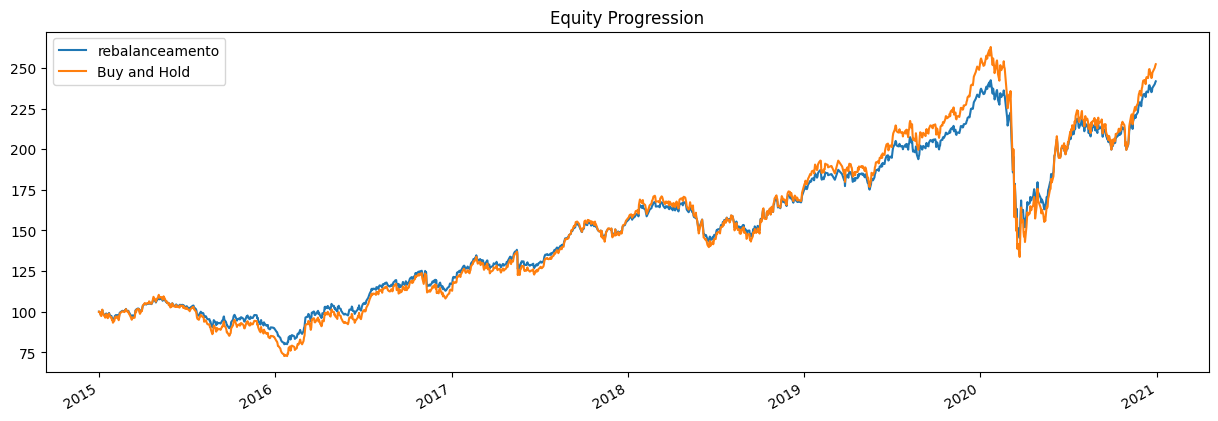

In [139]:
result.plot()

In [140]:
result.get_transactions()

price  quantity
Date       Security                      
2015-01-02 BOVA11     47.259998    8548.0
           CDI         1.000000  202000.0
           SMAL11     52.020000    7766.0
2015-01-30 BOVA11     45.610001     -67.0
           CDI         1.009293  -10350.0
...                         ...       ...
2020-10-30 CDI         1.639152   -3338.0
           SMAL11    107.800003     179.0
2020-11-30 BOVA11    105.000000    -245.0
           CDI         1.641602   50125.0
           SMAL11    126.699997    -368.0

[215 rows x 2 columns]

In [141]:
result.get_security_weights()

,BOVA11,SMAL11,CDI
2015-01-01,0.000000,0.000000,0.000000
2015-01-02,0.399979,0.399987,0.200000
2015-01-05,0.399650,0.396247,0.204068
2015-01-06,0.402691,0.392713,0.204562
2015-01-07,0.406714,0.393296,0.199956
...,...,...,...
2020-12-22,0.411273,0.396079,0.192594
2020-12-23,0.410620,0.398536,0.190790
2020-12-28,0.412090,0.398959,0.188897
2020-12-29,0.411431,0.400351,0.188166


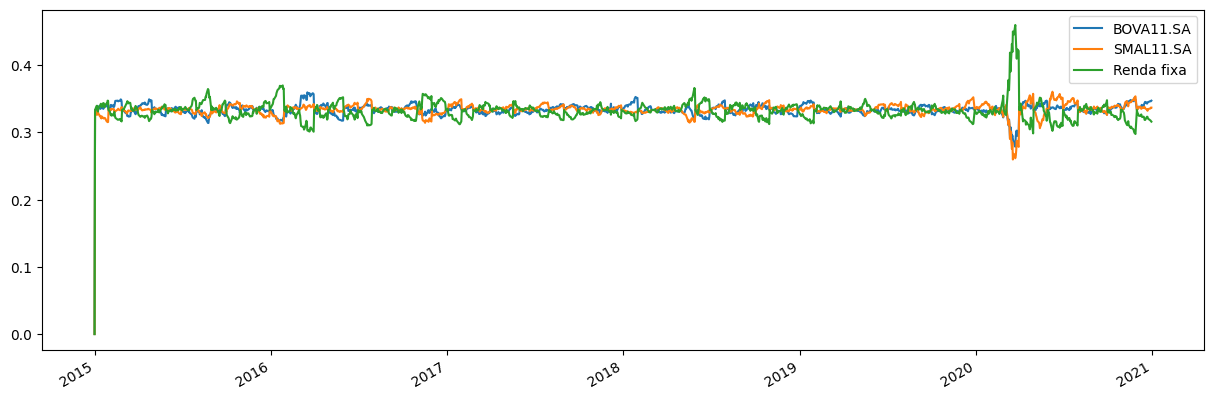

In [108]:
result.plot_security_weights()